<a href="https://colab.research.google.com/github/Shatokua/sent_analysis/blob/main/Aspect-Based%20Sentiment%20Analysis%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 29 05:49:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Аспектный анализ тональности

Конечной целью исследования является отладка модели для определения тональности текста по отношению к выбранному объекту текста, например, к упомянутой в тексте персоне, организации и т.д. 

Такой анализ является более точным, чем стандартный анализ тональности, и представляет больший интерес для конечных пользователей, поскольку дает оценку отношения к конкретному объекту, а не ко всему тексту.

## Подготовка окружения

In [2]:
%%capture
#@title Установка окружения

!pip install -q sklearn==0.22.2.post1
!pip install mendelai-brat-parser==0.0.4
!pip install smart_open==5.1.0
!pip install tensorflow-text==2.5.0
!pip install bert-for-tf2
!pip install -q tf-models-official

In [3]:
%%capture
#@title Импорт библиотек

import numpy as np
import pandas as pd
import os

from shutil import copyfile
from brat_parser import get_entities_relations_attributes_groups

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # для загрузки universal-sentence-encoder-cmlm/multilingual-preprocess
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import bert

from official.nlp import optimization

In [4]:
%%capture
#@title Определение рабочих директорий с данными
SOURCE_DIR1 = 'done/'
SOURCE_DIR2 = 'done1/'
BASE_DIR = 'train_test/'
main_csv_file = 'sent_quotes_done.csv'

## Изучение и подготовка данных

Данные представлены в виде текстовых файлов и файлов аннотаций в формате BRAT.
Все файлы находятся в двух папках done и done1. Файлы внутри папок не разделены по классам. Если в одном файле упоминается несколько объектов, по отношению к которым определяется тональность, данные находятся в одном файле ann.

Для работы в Tensorflow датасет может быть представлен в двух форматах:
1) как структурированный файл (например, csv), где каждая колонка является либо признаком, либо меткой класса;
2) набор файлов, распределенных по директориям-классам. 

Кроме того, в случаях, когда в тексте упоминаются несколько сущностей, необходимо создать отдельную копию текста для каждой из сущностей.

Подготовим данные для работы с Tensorflow
(**для последующей работы с Google Colab в дальнейшем будет использоваться сохраненный файл csv, исполнение следующих двух ячеек не требуется**).

In [5]:
%%capture
#@title Функция для перевода данных в читаемый TensorFlow формат

def files_to_df(source_dir, target_dir):
    """Собираем список файлов txt. 
    Идём по списку файлов, для каждого файла извлекаем текст сообщения (из txt), 
    текст объекта (ann), его индексы (ann), тональность (ann). 
    Раскладываем файлы на папки по классам, параллельно записываем в 
    dataframe pandas"""

    if (target_dir[:-1] not in os.listdir()):
      os.mkdir(target_dir)

    file_names = [fn[:-4] for fn in os.listdir(source_dir) if fn[-3:]=='txt']
    
    text_to_process = []
    
    for fn in file_names:
        txt_file_path = source_dir + fn +'.txt'
        
        with open(txt_file_path, encoding="utf8") as f:
            txt = f.read()
        
        ann_file_path = source_dir + fn +'.ann'
        entities, relations, attributes, groups = get_entities_relations_attributes_groups(ann_file_path)
        entities_keys = list(entities.keys())
        
        for key in entities_keys:
            class_dir = entities[key].type
            if (class_dir not in os.listdir(target_dir)):
                os.mkdir(target_dir + class_dir)
                
            entity_id = entities[key].id
            print(type(entities[key].span[0][0]))

            text_to_process.append({'filename':fn+'_'+entity_id, 'text': txt, 'entity_id': entities[key].id, 
                                    'entity_text': entities[key].text, 'entity_span_start': entities[key].span[0][0],
                                    'entity_span_end': entities[key].span[0][1], 'label': entities[key].type})
            
            txt_new_file_path = target_dir + class_dir + '/' + fn + '_' + entity_id +'.txt'
            copyfile(txt_file_path, txt_new_file_path)
            ent_new_file_path = target_dir + class_dir + '/' + fn + '_' + entity_id + '_entity' +'.txt'
            with open(ent_new_file_path, mode ='w', encoding ="utf8") as f:
              f.write(entities[key].text)
    
    df = pd.DataFrame.from_dict(text_to_process)
    return df


In [6]:
%%capture
#@title Изменение структуры папок, перенос данных в csv

#df1 = files_to_df(SOURCE_DIR1, BASE_DIR)
#df2 = files_to_df(SOURCE_DIR2, BASE_DIR)
#df = pd.concat([df1, df2])
#df.to_csv(main_csv_file)

Для работы в Google Colab требуется загрузка csv-файла.

In [7]:
%%capture
#@title Чтение файл csv

csv_file = main_csv_file
dataframe = pd.read_csv(csv_file)

Изучим распределение датасета по классам

In [8]:
%%capture
#@title Распределение классов


In [9]:
print(dataframe.value_counts('label'))

label
Neutral_all     29070
Neutral         10354
Negative         4836
Positive         4657
Negative_all     1782
Positive_all      923
Mixed             291
Mixed_all          15
dtype: int64


Классы несбалансированы. Класс Mixed_all состоит всего из 15 экземпляров. Укрупним классы, объединив классы с постфиксом _all с одноименными без префикса. Удалим записи, относящиеся к классу Mixed (Mixed_all)
Также приведем метки классов к числовым категориям

In [10]:
dataframe = dataframe[(dataframe['label']!='Mixed') & (dataframe['label']!='Mixed_all')]
print(dataframe.value_counts('label'))

label
Neutral_all     29070
Neutral         10354
Negative         4836
Positive         4657
Negative_all     1782
Positive_all      923
dtype: int64


In [11]:
%%capture
#@title Объединение классов, приведение меток классов к категориальному формату

classes = {'Positive': 0, 'Positive_all': 0, 
           'Negative': 1, 'Negative_all': 1, 
           'Neutral': 2, 'Neutral_all': 2}
dataframe['label'] = dataframe['label'].apply(lambda x: classes[x])

In [12]:
print(dataframe.value_counts('label'))

label
2    39424
1     6618
0     5580
dtype: int64


Разделим датасет на набор данных для тренировки и для тестирования.
В тренировочном датасете выделим набор для валидации

In [13]:
%%capture
#@title Разделение датасета на тренировочный и проверочный

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)


In [14]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

33037 train examples
8260 validation examples
10325 test examples


Поскольку классы не сбалансированы, проверим распределение по классам внутри тренировочного, тестового и валидационного датасетов

In [15]:
%%capture
#@title Проверка распределения классов


In [16]:
print('Нормализованное распределение по классам в начальном датасете')
print(dataframe.value_counts('label', normalize=True))

print('Нормализованное распределение по классам в датасете train')
print(train.value_counts('label', normalize=True))

print('Нормализованное распределение по классам в датасете test')
print(test.value_counts('label', normalize=True))

print('Нормализованное распределение по классам в датасете val')
print(val.value_counts('label', normalize=True))

Нормализованное распределение по классам в начальном датасете
label
2    0.763705
1    0.128201
0    0.108093
dtype: float64
Нормализованное распределение по классам в датасете train
label
2    0.764930
1    0.127736
0    0.107334
dtype: float64
Нормализованное распределение по классам в датасете test
label
2    0.758450
1    0.131622
0    0.109927
dtype: float64
Нормализованное распределение по классам в датасете val
label
2    0.765375
1    0.125787
0    0.108838
dtype: float64


Распределение классов одинаково во всех наборах. Выберем только колонки, которые нужны для работы модели.

In [17]:
train = train[['text', 'entity_span_start', 'entity_span_end', 'label']]
val = val[['text', 'entity_span_start', 'entity_span_end', 'label']]
test = test[['text', 'entity_span_start', 'entity_span_end', 'label']]

## Выбор модели

Для работы выбрана модель [LaBSE](https://tfhub.dev/google/LaBSE/2) (Language-agnostic BERT sentence embedding model) как одна из наиболее актуальных моделей, показывающих хорошие результаты для русского языка.

In [18]:
model_url = 'https://tfhub.dev/google/LaBSE/1'
labse_layer = hub.KerasLayer(model_url, trainable=False, name="LaBSE")

## Изменение препроцессора

Стандартный препроцессор получает на вход текст и выдает в качестве output словарь из трех тензоров:  
- `input_word_ids`: id поданных на вход слов  
- `input_mask`: маска из 1 и 0, где 1 находится на позициях значимых слов, 0 на позициях паддинга  
- `input_type_ids`: маска из 0 и 1 для передачи дополнительной информации о токенах

Нам необходимо изменить препроцессор таким образом, что в маске `input_type_ids` на позициях токенов интересующего нас объекта стояли 1, на всех остальных позициях - 0.

In [19]:
vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, entity_starts, entity_ends, tokenizer, max_seq_length):

  input_ids_all, input_mask_all, segment_ids_all = [], [], []
  for i in range (len(input_strings)):
    input_string = input_strings[i]
    entity_start = entity_starts[i]
    entity_end = entity_ends[i]


    #Токенизация строки до старта сущности
    input_tokens_before_entity = ["[CLS]"] + tokenizer.tokenize(input_string[:entity_start])
    input_ids_before_entity = tokenizer.convert_tokens_to_ids(input_tokens_before_entity)
    before_entity_length = len(input_ids_before_entity)

    #Токенизация сущности
    input_tokens_entity = tokenizer.tokenize(input_string[entity_start:entity_end])
    input_ids_entity = tokenizer.convert_tokens_to_ids(input_tokens_entity)
    entity_length = len(input_ids_entity)

    #Токенизация строки после окончания сущности
    input_tokens_after_entity = tokenizer.tokenize(input_string[entity_end:])+["[SEP]"]
    input_ids_after_entity = tokenizer.convert_tokens_to_ids(input_tokens_after_entity)
    after_entity_length = len(input_ids_after_entity)

    #Создание общего массива input_id
    input_ids = input_ids_before_entity + input_ids_entity + input_ids_after_entity
    sequence_length = before_entity_length+entity_length+after_entity_length

    #Массивы для маски и segment_id
    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)
    segment_ids = [0] * before_entity_length + [1] * entity_length + [0] * after_entity_length

    #Паддинг/обрезка
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
      segment_ids = segment_ids[:max_seq_length]
      input_mask = input_mask[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))
      segment_ids = segment_ids + [0]*(max_seq_length - len(segment_ids))
      input_mask = input_mask + [0]*(max_seq_length - len(segment_ids))

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append(segment_ids)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)




## Построение модели


In [20]:
def get_model(model_url, max_seq_length):
  

  # input
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

  # LaBSE layer
  labse_layer = hub.KerasLayer(model_url, trainable=True, name="LaBSE")
  pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

  # нормализация эмбеддинга
  pooled_output = tf.keras.layers.Lambda(
      lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)


  cls_out = tf.keras.layers.Dropout(0.5)(pooled_output)
  logits = tf.keras.layers.Dense(units=768, activation="tanh")(cls_out)
  cls_out = tf.keras.layers.Dropout(0.5)(pooled_output)
  logits = tf.keras.layers.Dense(units=3, activation="softmax")(logits)

  # Define model.
  return tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=logits)


labse_model = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=128)

In [21]:
labse_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
LaBSE (KerasLayer)              [(None, 768), (None, 470926849   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

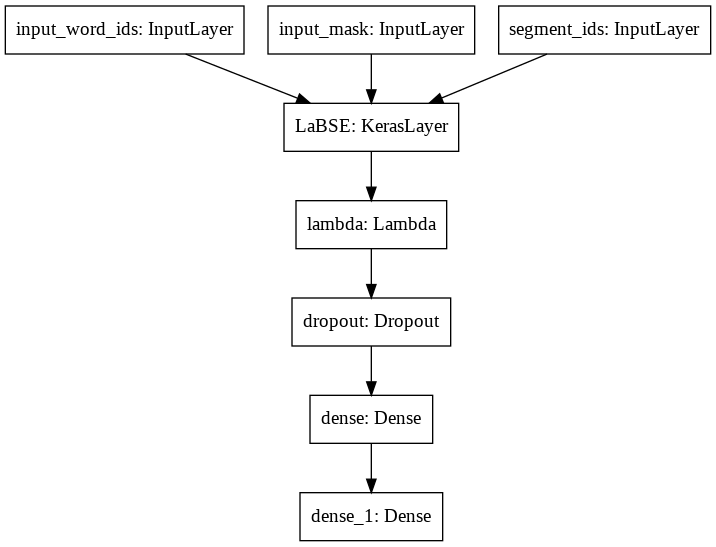

In [22]:
tf.keras.utils.plot_model(labse_model)

Проверим работу модели (выходные данные не несут смысла, поскольку модель не тренировалась).

In [23]:
test_text = dataframe['text'].to_list()[:10]
test_start = dataframe['entity_span_start'].to_list()[:10]
test_end = dataframe['entity_span_end'].to_list()[:10]
print(test_text)
print(test_start)
print(test_end)

['"да, я допустил неточность, а посол Мюррей ссылается на слухи... но зато теперь мы накопали много РЕАЛЬНОЙ информации на Усманова', '"да, я допустил неточность, а посол Мюррей ссылается на слухи... но зато теперь мы накопали много РЕАЛЬНОЙ информации на Усманова', '"Тот персонаж, о котором вы упомянули [Навальный]..., это тот человек, кого они[американская администрация] хотели бы продвинуть в политическую сферу России и видеть в руководстве страны", заметил Путин, подчеркнув, что США "в этом смысле прокололись', '"Тот персонаж, о котором вы упомянули [Навальный]..., это тот человек, кого они[американская администрация] хотели бы продвинуть в политическую сферу России и видеть в руководстве страны", заметил Путин, подчеркнув, что США "в этом смысле прокололись', '"Хотелось бы знать, Владимир Владимирович, сколько еще на своем посту пробудет губернатор Дарькин, который весь этот беспредел контролирует от начала и до конца и, мягко говоря, набивает карманы?" В ответ Путин пообещал учит

In [24]:
inputs = create_input(test_text, test_start, test_end, tokenizer, 128)

In [25]:
inputs

(array([[   101,    107,  15018, ...,      0,      0,      0],
        [   101,    107,  15018, ...,      0,      0,      0],
        [   101,    107, 222823, ...,      0,      0,      0],
        ...,
        [   101, 416659,  26834, ...,      0,      0,      0],
        [   101, 416659,  26834, ...,      0,      0,      0],
        [   101, 416659,  26834, ...,      0,      0,      0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [26]:

bert_raw_result = labse_model(inputs)
print(test_text[5])
print(bert_raw_result[5])

"Хотелось бы знать, Владимир Владимирович, сколько еще на своем посту пробудет губернатор Дарькин, который весь этот беспредел контролирует от начала и до конца и, мягко говоря, набивает карманы?" В ответ Путин пообещал учитывать сказанное "в будущей работе
tf.Tensor([0.32727468 0.3385863  0.33413902], shape=(3,), dtype=float32)


Модель выдает набор вероятностей, как и ожидалось.  
Компилируем модель.

In [29]:
labse_model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy']
)

## Тренировка модели

In [30]:
# Создание датасета
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  prepocessed_inputs = create_input(dataframe['text'].to_list(), dataframe['entity_span_start'].to_list(), 
                                    dataframe['entity_span_end'].to_list(), tokenizer, 128)  
  ds = tf.data.Dataset.from_tensor_slices((prepocessed_inputs, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

raw_train_ds = df_to_dataset(train, batch_size=batch_size)
raw_val_ds = df_to_dataset(val, batch_size=batch_size)
raw_test_ds = df_to_dataset(test, batch_size=batch_size)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
print(f'Training model')
history = labse_model.fit(x=train_ds, validation_data=val_ds, epochs=5)

Training model
Epoch 1/5
2065/2065 [==============================] - 741s 353ms/step - loss: 0.4568 - sparse_categorical_accuracy: 0.8282 - val_loss: 0.3682 - val_sparse_categorical_accuracy: 0.8523
Epoch 2/5
2065/2065 [==============================] - 727s 352ms/step - loss: 0.3155 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.3305 - val_sparse_categorical_accuracy: 0.8668
Epoch 3/5
2065/2065 [==============================] - 727s 352ms/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9186 - val_loss: 0.3304 - val_sparse_categorical_accuracy: 0.8764
Epoch 4/5
2065/2065 [==============================] - 727s 352ms/step - loss: 0.1579 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.3560 - val_sparse_categorical_accuracy: 0.8774
Epoch 5/5
2065/2065 [==============================] - 727s 352ms/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.8941


## График изменения точности и функции потерь

Оценим, как меняются точность и loss от эпохи к эпохе на тренировочном и валидационном датасетах на графике.

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


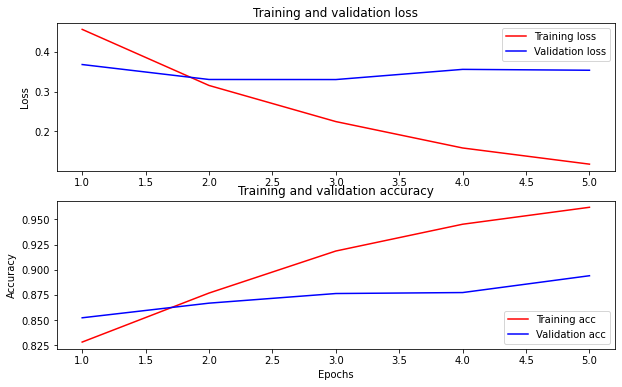

In [33]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Оценка точности на тренировочном датасете

In [34]:
loss, accuracy = labse_model.evaluate(test_ds)

646/646 [==============================] - 53s 82ms/step - loss: 0.3690 - sparse_categorical_accuracy: 0.8910


In [35]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.36899903416633606
Accuracy: 0.8910411596298218


Таким образом, точность (accuracy) для незнакомых текстов составляет около 89%, что сопоставимо с состоянием state-of-art для задачи аспектного анализа тональности на текущий момент (2021 год).  
[Таблица state-of-art для задачи аспектного анализа тональности](https://paperswithcode.com/sota/aspect-based-sentiment-analysis-on-semeval)

## Оценка precision, recall и F1 по классам

In [ ]:
# predict probabilities for test set
test_probs = labse_model.predict(test_ds, verbose=0)
# predict crisp classes for test set
test_classes = model.predict_classes(test_ds, verbose=0)
test_probs

## Сохранение модели

ResourceExhaustedError: ignored

In [52]:
labse_model2 = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=128)

In [55]:
labse_model2.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy']
)
loss, accuracy = labse_model2.evaluate(test_ds)

646/646 [==============================] - 53s 82ms/step - loss: 1.1039 - sparse_categorical_accuracy: 0.2863


InternalError: ignored

In [1]:
test_results = labse_model(test_ds)

NameError: ignored